# Data preparation for VAST 2017 Mini Challenge 2


#### TODO:
* See if there's something better to do with the non-unique sensor readings than just excluding them
* check wind distances for accuracy and usefulness

In [1]:
from collections import OrderedDict
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy as sp
from scipy.interpolate import interp1d

from vast_2017_mc2 import dat_path, source_file_excel, source_file_pickle

sns.set_style()
%matplotlib inline

## Parameters

In [2]:
source_file = {'manual': dat_path/'modified/manual.xlsx',
               'wind': dat_path/'supplied/Meteorological Data.xlsx',
               'sensor': dat_path/'supplied/Sensor Data.xlsx',
              }

km_per_grid_unit = 12 * 1.609 / 200  # <grid size miles> * <km per mile> / <# of grid units>
column_name_mappings = {
    'wind': {'Date': 'timestamp', 
             'Wind Direction': 'direction', 
             'Wind Speed (m/s)': 'speed'},
    'sensor': {'Chemical': 'chemical', 
               'Monitor': 'monitor', 
               'Date Time ': 'timestamp', 
               'Reading': 'reading'},
    }

## Load

In [3]:
locations = pd.read_excel(source_file['manual'], sheetname='locations', index_col='name')
wind = pd.read_excel(source_file['wind']).iloc[:,:3].dropna()
wind.columns = [column_name_mappings['wind'].get(c, c) for c in wind.columns]
wind.set_index('timestamp', inplace=True)
wind.sort_index(inplace=True)
sensor = pd.read_excel(source_file['sensor']).dropna()
sensor.columns = [column_name_mappings['sensor'].get(c, c) for c in sensor.columns]
sensor.set_index(['chemical', 'monitor', 'timestamp'], inplace=True)
sensor.sort_index(inplace=True)
sensor.head(2)

reading
chemical monitor timestamp                    
AGOC-3A  1       2016-04-01 00:00:00  0.160462
                 2016-04-01 01:00:00  0.065606

In [4]:
wind.head(2)

,direction,speed
timestamp,,
2016-04-01 00:00:00,190.5,4.0
2016-04-01 03:00:00,203.3,5.0


## Completeness checks

In [5]:
def cell_counts(df):
    result = df.groupby(df.index).count()
    if isinstance(df.index, pd.MultiIndex):
        result.index = pd.MultiIndex.from_tuples(result.index, names=df.index.names)
    return result
    
def cell_counts_not_1(df):
    result = cell_counts(df)
    result = result[(result!=1).any(axis='columns')]
    return result
cell_counts_not_1(wind)

,direction,speed
timestamp,,


In [6]:
cell_counts(sensor).unstack(['chemical', 'monitor']).fillna(0).astype(int).head()

reading                                     ...  \
chemical            AGOC-3A                         Appluimonia ...   
monitor                   1  2  3  4  5  6  7  8  9           1 ...   
timestamp                                                       ...   
2016-04-01 00:00:00       1  1  1  1  1  1  1  1  1           1 ...   
2016-04-01 01:00:00       1  1  1  1  1  1  1  1  1           1 ...   
2016-04-01 02:00:00       1  1  1  1  1  1  1  1  1           1 ...   
2016-04-01 03:00:00       1  1  1  1  1  1  1  1  1           1 ...   
2016-04-01 04:00:00       1  1  1  1  1  1  1  1  1           1 ...   

                                                                         
chemical            Chlorodinine Methylosmolene                          
monitor                        9              1  2  3  4  5  6  7  8  9  
timestamp                                                                
2016-04-01 00:00:00            1              1  1  1  1  1  1  1  1  1  
2016-04-01 01:00:00            1              1  1  1  1  1  1  1  1  1  
2016-04-01 02:00:00            1              1  1  1  1  1  1  1  1  1  
2016-04-01 03:00:00            1              1  1  1  1  1  1  1  1  1  
2016-04-01 04:00:00            1              1  1  1  1  1  1  1  1  1  

[5 rows x 36 columns]

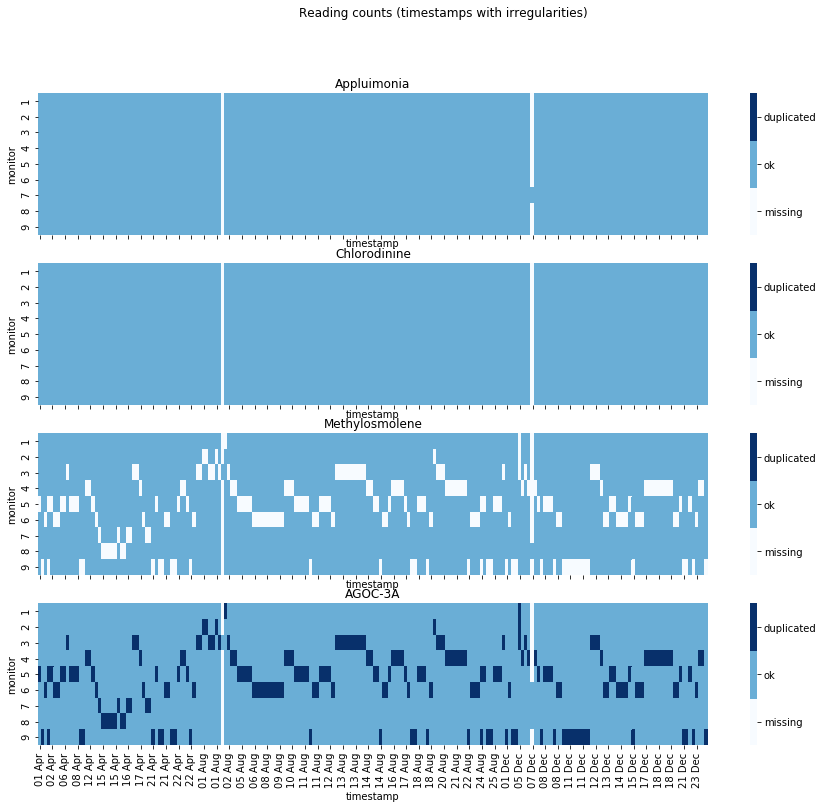

In [20]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
only_irregularities = True
counts = cell_counts(sensor).unstack(['chemical', 'monitor']).fillna(0).astype(int)['reading']
if only_irregularities:
    counts = counts[(counts != 1).any(axis='columns')]
chemicals = counts.columns.get_level_values('chemical').unique().values
chemicals = chemicals[(np.arange(len(chemicals))+1) % len(chemicals)]
count_vals = np.arange(counts.max().max()+1)
def count_label(count_val):
    if count_val == 0: return 'missing'
    if count_val == 1: return 'ok'
    if count_val > 1: return 'duplicated'
count_cmap = LinearSegmentedColormap.from_list('count_cmap', plt.get_cmap('Blues')(count_vals/np.max(count_vals)), len(count_vals))
fig, axs = plt.subplots(nrows=len(chemicals), sharex=True, figsize=(15, 3*len(chemicals)))
for chemical, ax in zip(chemicals, axs.flatten()):
    sns.heatmap(counts[chemical].T, cmap=count_cmap, vmin=0, vmax=2, ax=ax)
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks((count_vals+0.5)*(len(count_vals)-1)/len(count_vals))
    colorbar.set_ticklabels(list(map(count_label, count_vals)))
    colorbar.set_label('')
    ax.set_xticklabels(pd.to_datetime([t.get_text() for t in ax.get_xticklabels()]).strftime('%d %h'))
    ax.set_title(chemical)
plt.suptitle('Reading counts ({})'.format('timestamps with irregularities' if only_irregularities else 'all timestamps'))
plt.show()

## Calculations

In [8]:
def enhance_locations():
    for direction in ['east', 'north']:
        locations['{direction}_km'.format(**locals())] = locations['{direction}_gu'.format(**locals())] * km_per_grid_unit
enhance_locations()
locations.head(2)

,east_gu,north_gu,type,east_km,north_km
name,,,,,
Roadrunner Fitness Electronics,89,27,factory,8.59206,2.60658
Kasios Office Furniture,90,21,factory,8.68860,2.02734


In [9]:
def get_subperiods():
    wind_timestamps = np.sort(np.unique(wind.index.values))
    wind_intervals = wind_timestamps[1:] - wind_timestamps[:-1]
    is_bound = wind_intervals > (np.max(wind_intervals) / 2)
    bounds = np.sort(np.r_[wind_timestamps[:-1][is_bound],  wind_timestamps[1:][is_bound], wind_timestamps[[0, -1]]])
    result = pd.DataFrame.from_items([('start', np.r_[np.nan, bounds]), 
                                      ('end', np.r_[bounds, np.nan]),
                                      ('has_wind_data', ((np.arange(len(bounds)+1)) % 2).astype(bool)),
                                     ])
    return result
subperiods = get_subperiods()

def subperiods_for_timestamps(timestamps):
    bounds = subperiods['end'].values[:-1]
    rows = (timestamps.reshape((-1,1)) > bounds.reshape((1,-1))).sum(axis=1).flatten()
    return subperiods.index.values[rows]

In [10]:
wind['subperiod'] = subperiods_for_timestamps(wind.index.values)

In [11]:
def get_final_plume_shapes():
    def get_subperiod_fine_displacements(period_name, subperiod):
        wind_angles = sp.interpolate.interp1d(x=wind.index.values.astype(float), y=np.unwrap(np.deg2rad(wind['direction'].values)), kind='linear')
        wind_speed = sp.interpolate.interp1d(x=wind.index.values.astype(float), y=wind['speed'].values, kind='linear')
        result = pd.DataFrame(index=pd.date_range(start=subperiod['start'], end=subperiod['end'], freq='min'))
        result.index.name = 'emission_time'
        result['subperiod'] = period_name
        float_timesteps = result.index.values.astype(float)
        speed = wind_speed(float_timesteps)
        angle = wind_angles(float_timesteps)
        result['emission_wind_speed'] = speed
        result['emission_wind_angle'] = np.rad2deg(angle) % 360
        interval_seconds = (result.index.shift(1) - result.index).total_seconds().values
        for col, trig_func in [('east_km', np.sin), ('north_km', np.cos)]:
            # cumulative displacement in km
            result[col] = np.flipud(np.cumsum(np.r_[0, np.flipud(- speed * trig_func(angle) * interval_seconds / 1000 )[1:]]))
        return result
    return pd.concat(get_subperiod_fine_displacements(name, dets) for name, dets in subperiods[subperiods['has_wind_data']].iterrows())
    
final_plume_shapes = get_final_plume_shapes()
final_plume_shapes.head(2)

,subperiod,emission_wind_speed,emission_wind_angle,east_km,north_km
emission_time,,,,,
2016-04-01 00:00:00,1,4.000000,190.500000,2328.522616,-1095.425925
2016-04-01 00:01:00,1,4.005556,190.571111,2328.478879,-1095.661906


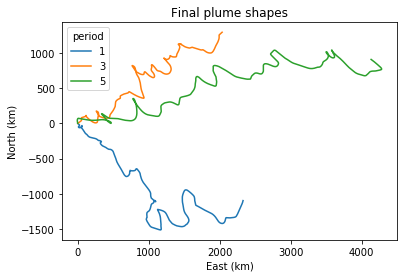

In [12]:
plt.figure()
period_indices = final_plume_shapes['subperiod'].unique()
for p in period_indices:
    to_plot = final_plume_shapes[final_plume_shapes['subperiod'] == p]
    plt.plot(to_plot['east_km'].values, to_plot['north_km'].values, label=p)
plt.legend(title='period')
plt.title('Final plume shapes')
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.show()

In [13]:
def mark_unique_sensor_readings():
    sensor_index_counts = sensor.groupby(sensor.index).size()
    unique_reading_indices = sensor_index_counts[sensor_index_counts==1].index
    sensor['unique'] = sensor.index.isin(unique_reading_indices)
mark_unique_sensor_readings()
sensor.head(2)

reading  unique
chemical monitor timestamp                            
AGOC-3A  1       2016-04-01 00:00:00  0.160462    True
                 2016-04-01 01:00:00  0.065606    True

In [14]:
def get_sensor_wind_distance_and_readings(max_plume_distance=50):
    def partial_concentrations(diffusion_rate, distance_sq, age):
        return np.exp(-distance_sq / (2 * diffusion_rate * diffusion_rate * age)) / (diffusion_rate * np.sqrt(2 * np.pi * age))
    def highest_concentration_diffusion_rate(distance_sq, age):
        valid = (distance_sq > 0) & (age > 0)
        distance_sq = distance_sq[valid]
        age = age[valid]
        standalone_rate = np.sqrt(distance_sq/age)
        ndx_highest_standalone = np.argmax(partial_concentrations(standalone_rate, distance_sq, age))
        def negative_total_concentration(diffusion_rate):
            return - partial_concentrations(diffusion_rate, distance_sq, age).sum()
        minimized = sp.optimize.minimize(negative_total_concentration, standalone_rate[ndx_highest_standalone])
        return minimized.x[0] if minimized.success else np.nan
    periods = subperiods[subperiods['has_wind_data']]
    factory_locations = locations[locations['type'] == 'factory'].reset_index()
    sensor_locations = locations[locations['type'] == 'sensor'].reset_index()
    coord_cols = ['east_km', 'north_km']
    # direction * sensor * factory
    sensor_factory_displacements = np.expand_dims(sensor_locations[coord_cols].values.T,2) - np.expand_dims(factory_locations[coord_cols].values.T, 1)
    sensor_timestamps = sensor.index.get_level_values('timestamp').unique()
    component_dfs = []
    for period in rows_as_series(periods.reset_index()):
        period_plume_shape = final_plume_shapes[final_plume_shapes['subperiod'] == period['index']]
        period_emission_seconds = (lambda x: (x-x[0]).total_seconds().values)(period_plume_shape.index)
        period_plume_shape_coords = period_plume_shape[coord_cols].values
        measurement_times = sensor_timestamps.copy()
        if not pd.isnull(period['end']): measurement_times = measurement_times[measurement_times <= period['end']]
        if not pd.isnull(period['start']): measurement_times = measurement_times[measurement_times > period['start']]
        measurement_rows = np.searchsorted(period_plume_shape.index, measurement_times)
        assert all(period_plume_shape.index.values[measurement_rows] == measurement_times.values)
        diff_rates = []
        for measurement_row, measurement_time in zip(measurement_rows, measurement_times):
            plume_displacements = period_plume_shape_coords[measurement_row].reshape(1,-1)- period_plume_shape_coords[:measurement_row,:]
            plume_distance = np.sqrt((plume_displacements*plume_displacements).sum(axis=1))
            within_range = plume_distance < max_plume_distance
            plume_age_seconds = period_emission_seconds[measurement_row] - period_emission_seconds[:measurement_row]
            plume_displacements = plume_displacements[within_range, ...]
            plume_age_seconds = plume_age_seconds[within_range]
            sensor_distance_components = np.reshape(plume_displacements.T, (2,1,1,-1)) - np.expand_dims(sensor_factory_displacements, 3)
            sensor_squared_distances = (sensor_distance_components*sensor_distance_components).sum(axis=0)
            diff_rates.append(np.apply_along_axis(highest_concentration_diffusion_rate, -1, sensor_squared_distances, age=plume_age_seconds))
        diff_rates = np.array(diff_rates).transpose(1,2,0) # sensor * facory * timestep
        partial_result = pd.DataFrame(index=pd.Index(measurement_times, name='timestamp'))
        for sensor_dets, sensor_rates in zip(rows_as_series(sensor_locations), diff_rates):
            for factory_dets, factory_rates in zip(rows_as_series(factory_locations), sensor_rates):
                partial_result[('wind_distance', sensor_dets['name'], factory_dets['name'])] = factory_rates
        component_dfs.append(partial_result)
    result = pd.concat(component_dfs)
    result.columns = pd.MultiIndex.from_tuples(result.columns, names=['stat', 'monitor', 'item'])
    result = result.stack('monitor')
    index_names = result.index.names
    columns_names = result.columns.names
    result.index = result.index.values
    result.columns = result.columns.values
    sensor_copy = sensor.copy().unstack('chemical')
    sensor_copy.columns.names = ['item', 'stat']
    sensor_copy.reorder_levels(columns_names, axis='columns')
    sensor_copy.reorder_levels(index_names, axis='index')
    result = result.join(sensor_copy)
    result.index = pd.MultiIndex.from_tuples(result.index, names=index_names)
    result.columns = pd.MultiIndex.from_tuples(result.columns, names=column_names)
    return result
#sensor_wind_distance_and_readings = get_sensor_wind_distance_and_readings()
#sensor_wind_distance_and_readings.head(2)

In [15]:
def get_all_joined():
    result = sensor.loc[sensor['unique'], [c for c in sensor.columns if c != 'unique']].copy()
    ref_timestamp = wind.index.values[0]
    def numeric_timestamp(x):
        return (x - ref_timestamp).astype(float)
    def raw_wind_interp(values):
        return interp1d(numeric_timestamp(wind.index.values), 
                        values.astype(float), 
                        fill_value=tuple(values[[0, -1]]),
                        bounds_error=False,
                       )
    target_timestamps = numeric_timestamp(result.index.get_level_values('timestamp').values)
    result['wind_speed'] = raw_wind_interp(wind['speed'].values)(target_timestamps)
    result['wind_direction'] = raw_wind_interp(np.rad2deg(np.unwrap(np.deg2rad(wind['direction'].values))))(target_timestamps) % 360
    result['subperiod'] = subperiods_for_timestamps(result.index.get_level_values('timestamp').values)
    result = result.join(subperiods['has_wind_data'], on='subperiod')
    sensor_locations = locations.loc[locations['type'] == 'sensor', ['east_km', 'north_km', 'name']]
    sensor_locations.index.name = 'monitor'
    sensor_locations.columns = ['sensor_{}'.format(c) for c in sensor_locations.columns]
    result = result.join(sensor_locations)
    return result
all_joined = get_all_joined()
all_joined.head(2)

reading  wind_speed  wind_direction  \
chemical monitor timestamp                                                   
AGOC-3A  1       2016-04-01 00:00:00  0.160462    4.000000      190.500000   
                 2016-04-01 01:00:00  0.065606    4.333333      194.766667   

                                      subperiod  has_wind_data  \
chemical monitor timestamp                                       
AGOC-3A  1       2016-04-01 00:00:00          0          False   
                 2016-04-01 01:00:00          1           True   

                                      sensor_east_km  sensor_north_km  \
chemical monitor timestamp                                              
AGOC-3A  1       2016-04-01 00:00:00         5.98548          2.02734   
                 2016-04-01 01:00:00         5.98548          2.02734   

                                      sensor_name  
chemical monitor timestamp                         
AGOC-3A  1       2016-04-01 00:00:00          NaN  
                 2016-04-01 01:00:00          NaN

## Inspection

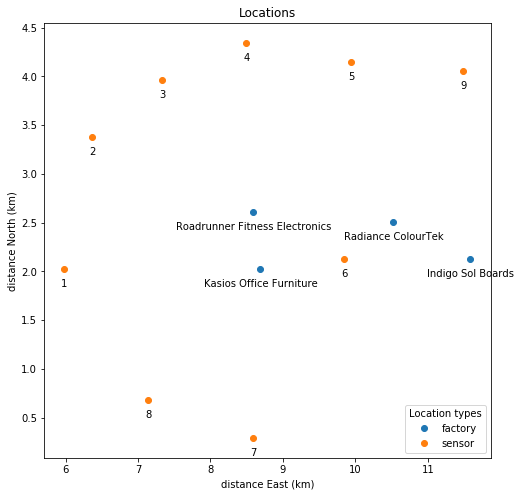

In [16]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
for loc_type in locations['type'].unique():
    data = locations[locations['type'] == loc_type]
    plt.plot(data['east_km'].values, data['north_km'].values, 'o', label=loc_type)
    data.reset_index().apply(lambda row: plt.text(row['east_km'], row['north_km']-0.1, row['name'], ha='center', va='top'), axis='columns')
plt.title('Locations')
plt.legend(loc='lower right', title='Location types')
plt.xlabel('distance East (km)')
plt.ylabel('distance North (km)')
plt.show()

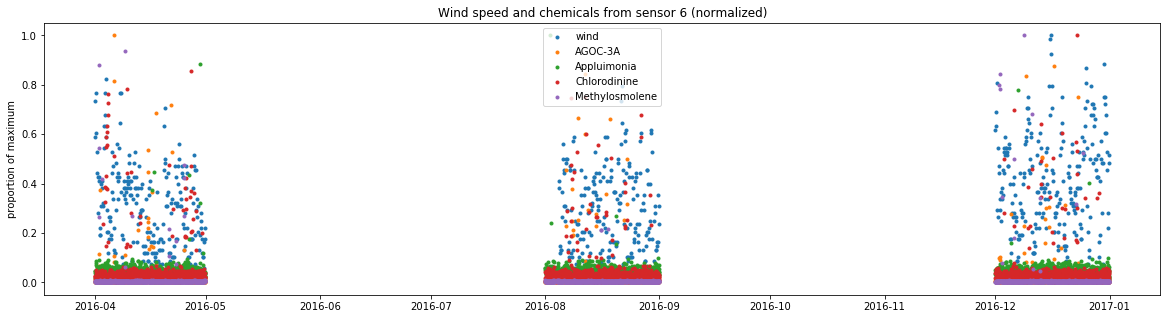

In [17]:
plt.figure(figsize=(20,5))
plt.plot(wind.index.values, (wind['speed'] / wind['speed'].max()).values, '.', label='wind')
for chemical in sensor.index.get_level_values('chemical').unique():
    data = sensor.loc[chemical,:].loc[6,'reading']
    data /= data.max()
    plt.plot(data.index.values, data.values, '.', label=chemical)
plt.legend()
plt.title('Wind speed and chemicals from sensor 6 (normalized)')
plt.ylabel('proportion of maximum')
plt.show()

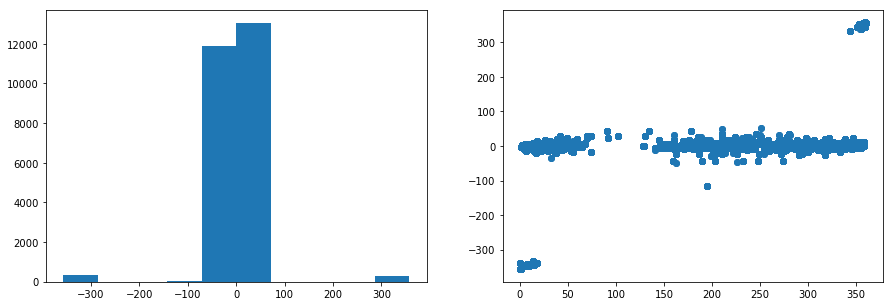

In [18]:
to_plot = all_joined[all_joined['subperiod'] == 1].reset_index().set_index('timestamp')[['wind_direction']]
to_plot['change'] = to_plot['wind_direction'] - to_plot['wind_direction'].shift(1)
to_plot.dropna(inplace=True)
fig, axs = plt.subplots(ncols=2, figsize=(15,5))
axs[0].hist(to_plot['change'].values)
axs[1].plot(to_plot['wind_direction'].values, to_plot['change'].values, 'o')
plt.show()

## Save

In [19]:
to_save = OrderedDict([
                       ('all_joined', all_joined),
                       ('sensor', sensor),
                       ('wind', wind),
                       ('locations', locations),
                       ('subperiods', subperiods),
                       ('final_plume_shapes', final_plume_shapes),
#                       ('sensor_wind_distance_and_readings', sensor_wind_distance_and_readings),
                      ])
# excel
with pd.ExcelWriter(source_file_excel) as writer:
    for sheet_name, content in to_save.items():
        if isinstance(content.index, pd.MultiIndex) or content.index.name:
            content = content.reset_index()
        content.to_excel(writer, sheet_name=sheet_name, index=False)
# pickle
pd.to_pickle(to_save, str(source_file_pickle))